# Mathematical formulation

In [1]:
import numpy as np
from scipy.stats import spearmanr, logistic, t as tstat
from statsmodels.stats.multitest import multipletests
from scipy.special import logit, expit
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from glob import glob
import os
import h5py
from utils.utils import plot_root_intervals, get_max

pd.set_option('display.max_columns', 150)

# Problems with the procedure

## Explore the original procedure

### Single cell artificial data

In [5]:
#get weights from beta clocks
clocks = pd.read_csv('clock_data/beta.csv', index_col=0)
method, alpha = 'bonferroni', 0.01
n_corrected_sites = clocks['PearsonP'][multipletests(clocks['PearsonP'], method=method, alpha=alpha)[0]].shape[0]
print(f'Survived after {method} correction {n_corrected_sites} sites at s.level={alpha}')

#get top n from them based on the absolute value of correlation
# top = 5000
# top_idx = clocks['PearsonR'].abs().sort_values(ascending=False)[:top].index
# top_sites = clocks.loc[top_idx]

#get top n/2 positive and n/2 negative from them based on the value of correlation
top = 5000
top_idx_pos = clocks['PearsonR'].sort_values(ascending=False)[:top//2].index
top_idx_neg = clocks['PearsonR'].sort_values(ascending=True)[:top//2].index
top_idx = top_idx_pos.tolist() + top_idx_neg.tolist()
top_sites = clocks.loc[top_idx]

Survived after bonferroni correction 815 sites at s.level=0.01


In [6]:
n_steps = 2000
m_cells = 100
interval_of_search = (-20, 50)

#get weights and biases
w_ = np.asarray(top_sites['Coef'])
b_ = np.asarray(top_sites['Intercept'])

probs = np.zeros((m_cells, n_steps))
x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'p':[]})
for p_met in np.linspace(0, 1.0, 12):
    for cell in range(m_cells):
        mask = np.random.binomial(1, p=p_met, size=top).astype(bool)
        for i, xi in enumerate(x):
            p = expit(w_ * xi + b_)
            p = np.where(mask, p, 1-p)
            probs[cell, i] = np.log(p).sum()

    x_opt = np.array([x[i] for i in np.argmax(probs, axis=1)])
    data = pd.concat([data, pd.DataFrame({'Ages':x_opt, "p":round(p_met, 2)})])

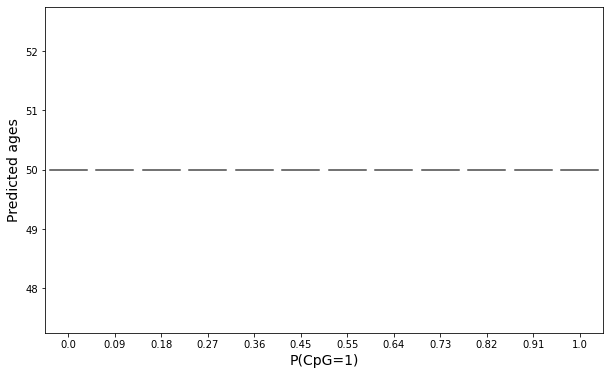

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.violinplot(x='p', y='Ages', data=data, ax=axes)
axes.set_xlabel('P(CpG=1)', fontsize=14)
axes.set_ylabel('Predicted ages', fontsize=14);

### Real data

Here we reproduce the original procedure and obtain ground truth result.

In [9]:
### CHOOSE THE DATASET from {embryo, liver, muscle}
dataset = 'muscle'

if dataset == 'embryo':
    #embryogenesis
    meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
    meta['stage'] = meta['characteristics_ch1.1.developmental stage']
    stages = sorted(meta['stage'].unique().tolist())
    list_cells = glob('cell_data/cells/*.h5')
    file_format = '.h5'
    gse_id = 'GSE121690_cells'
elif dataset == 'liver':
    #liver aging
    meta = pd.read_csv('cell_data/SRA344045_metadata.tsv', index_col=0, sep='\t')
    meta['stage'] = meta['Tissue-Age']
    stages = sorted(meta['stage'].unique().tolist())[::-1]
    list_cells = glob('cell_data/SRA344045_cells/*.tsv')
    file_format = '.tsv'
    gse_id = 'SRA344045_cells'
elif dataset == 'muscle':
    #muscle stem cell aging
    meta = pd.read_csv('cell_data/GSE121436_metadata.csv', index_col=0)
    meta['stage'] = meta['characteristics_ch1.2.age']
    stages = sorted(meta['stage'].unique().tolist())
    list_cells = glob('cell_data/GSE121436_cells/*.tsv')
    file_format = '.tsv'
    gse_id = 'GSE121436_cells'
else:
    raise NotImplementedError('No such dataset')

In [10]:
######
n_steps = 2000
interval_of_search = (-20, 50) #CUSTOM INTERVAL IN SCOPE
######

x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    skip_counter = 0
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        ### read data ###
        path = f'cell_data/{gse_id}/{cell_name}{file_format}'
        assert os.path.exists(path)
        if file_format == '.h5':
            cell_df = pd.read_hdf(path)
        elif file_format == '.tsv':
            cell_df = pd.read_csv(path, sep='\t', index_col=0)
            
        ### filter data ###
        #coverage check
        if cell_df.shape[0] < 500_000: 
            skip_counter += 1
            continue    
        #common sites check
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        if len(common_sites) == 0: 
            skip_counter += 1
            #print('No common')
            continue
            
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites].iloc[:, 0].values
        global_methylation = np.mean(cell_df.iloc[:, 0].values)
        probs = []
        for i, xi in enumerate(x):
            p = expit(w_ * xi + b_)
            p = np.where(mask, p, 1-p)
            probs.append(np.log(p).sum())
        cell_ages.append(x[np.argmax(probs)])
        n_common_sites.append(len(common_sites))
        methyl_prob.append(np.mean(mask))
        methyl_prob_cell.append(global_methylation)
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])

100%|██████████| 91/91 [01:15<00:00,  1.20it/s]


In [11]:
print(data.groupby('Stage').count().iloc[:, 0])
data.groupby('Stage').mean()

Stage
2 months     161
24 months     44
Name: Ages, dtype: int64


,Ages,n_sites,p_empiric,p_empiric_full_cell
Stage,,,,
2 months,16.800139,547.155280,0.116554,0.487085
24 months,23.871368,683.204545,0.134703,0.518067


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04



ValueError: box_pairs contains an invalid box pair.

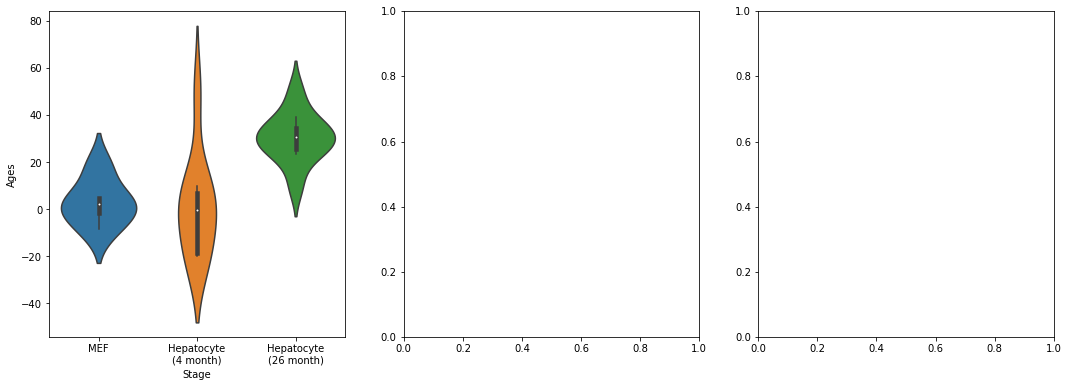

In [7]:
from statannot import add_stat_annotation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
test_results = add_stat_annotation(axes[0], data=data, x='Stage', y='Ages',
                                   box_pairs=[('E4.5', 'E5.5'), 
                                              ('E5.5', 'E6.5'),
                                              ('E6.5', 'E7.5')
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=1)
axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MEF v.s. Hepatocyte
(4 month): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.500e+01
Hepatocyte
(4 month) v.s. Hepatocyte
(26 month): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.466e-03 U_stat=9.500e+00


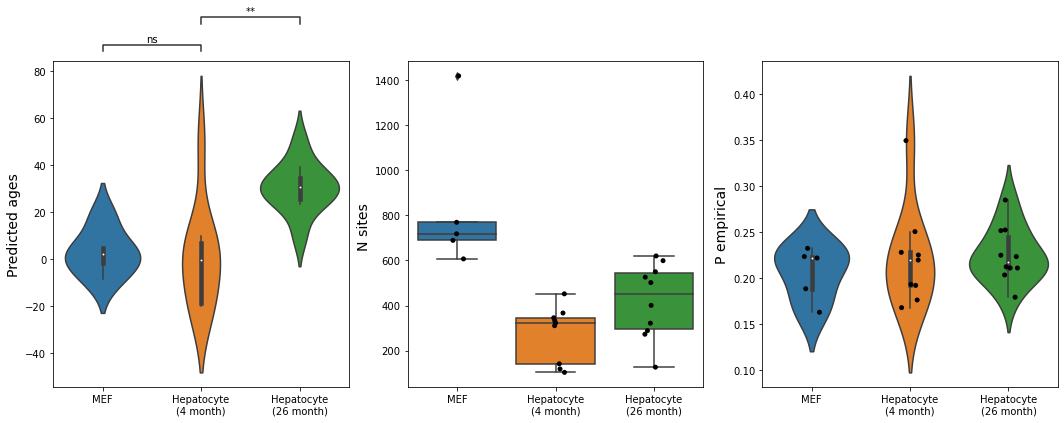

In [8]:
from statannot import add_stat_annotation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
test_results = add_stat_annotation(axes[0], data=data, x='Stage', y='Ages',
                                   box_pairs=[('MEF', 'Hepatocyte\n(4 month)'), 
                                              ('Hepatocyte\n(4 month)', 'Hepatocyte\n(26 month)'),
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=1)

axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2 months v.s. 24 months: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.920e-04 U_stat=2.241e+03


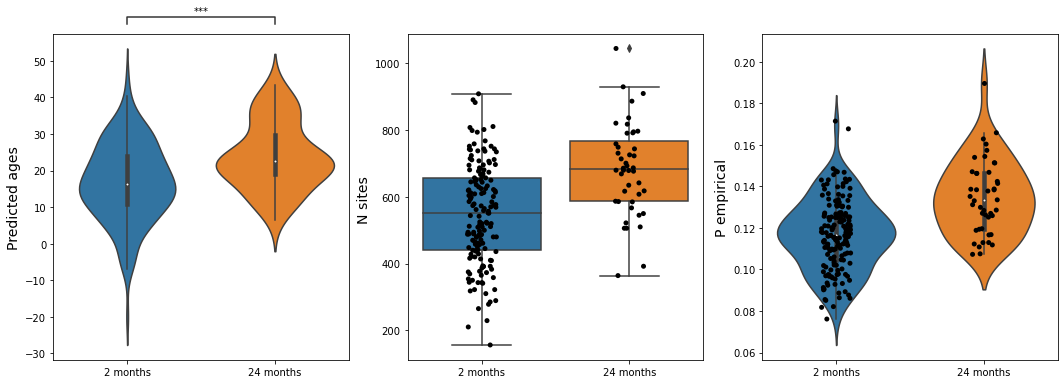

In [12]:
from statannot import add_stat_annotation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
test_results = add_stat_annotation(axes[0], data=data, x='Stage', y='Ages',
                                   box_pairs=[('2 months', '24 months'), 
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=1)

axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);

# Torch optimization procedure

In [11]:
import torch 
from utils.utils import BetaModel

def minimize_beta_model(c, model, optimizer, delta=0.005, threshold_n_elem=5):
    t_list, ll_score = [], []
    count = 0
    opt_step = 0
    while count <= threshold_n_elem:
        ll = -torch.sum(model(c))
        ll.backward()
        optimizer.step()
        optimizer.zero_grad()
        ll_score.append(ll.item())
        t_list.append(model.t.item())

        if (opt_step != 0) and (np.abs(t_list[-2] - t_list[-1]) <= delta):
            count += 1
        else: 
            count = 0
            
        opt_step += 1

    return (t_list[-1], t_list, ll_score, opt_step)

### Artificial data

In [46]:
m_cells = 100
#get weights and biases
w_ = torch.tensor(np.asarray(top_sites['Coef']))
b_ = torch.tensor(np.asarray(top_sites['Intercept']))
##
t0 = torch.tensor([-10.]) #initial condition

ages = np.zeros((m_cells))
data = pd.DataFrame({'Ages':[], 'p':[]})
for p_met in tqdm(np.linspace(0, 1.0, 12)):
    for cell in range(m_cells):
        c = torch.bernoulli(torch.ones(top) * p_met).to(torch.float)
        model = BetaModel(w_, b_, t0)
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-1)
        ages[cell], *_ = minimize_beta_model(c, model, optimizer, 
                                      delta=0.01, threshold_n_elem=10)
    data = pd.concat([data, pd.DataFrame({'Ages':ages, "p":round(p_met, 2)})])

100%|██████████| 12/12 [00:30<00:00,  2.57s/it]


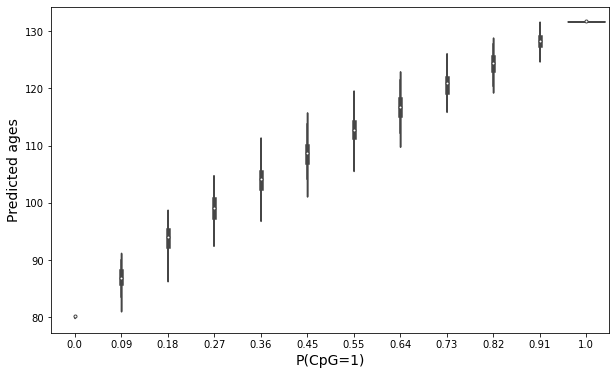

In [47]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.violinplot(x='p', y='Ages', data=data, ax=axes)
axes.set_xlabel('P(CpG=1)', fontsize=14)
axes.set_ylabel('Predicted ages', fontsize=14);

### Real data

In [57]:
### CHOOSE THE DATASET from {embryo, liver, muscle}
dataset = 'embryo'

if dataset == 'embryo':
    #embryogenesis
    meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
    meta['stage'] = meta['characteristics_ch1.1.developmental stage']
    stages = sorted(meta['stage'].unique().tolist())
    list_cells = glob('cell_data/cells/*.h5')
    file_format = '.h5'
    gse_id = 'GSE121690_cells'
elif dataset == 'liver':
    #liver aging
    meta = pd.read_csv('cell_data/SRA344045_metadata.tsv', index_col=0, sep='\t')
    meta['stage'] = meta['Tissue-Age']
    stages = sorted(meta['stage'].unique().tolist())[::-1]
    list_cells = glob('cell_data/SRA344045_cells/*.tsv')
    file_format = '.tsv'
    gse_id = 'SRA344045_cells'
elif dataset == 'muscle':
    #muscle stem cell aging
    meta = pd.read_csv('cell_data/GSE121436_metadata.csv', index_col=0)
    meta['stage'] = meta['characteristics_ch1.2.age']
    stages = sorted(meta['stage'].unique().tolist())
    list_cells = glob('cell_data/GSE121436_cells/*.tsv')
    file_format = '.tsv'
    gse_id = 'GSE121436_cells'
else:
    raise NotImplementedError('No such dataset')

In [58]:
t0 = torch.tensor([10.]) #initial condition
data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    skip_counter = 0
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        ### read data ###
        path = f'cell_data/{gse_id}/{cell_name}{file_format}'
        assert os.path.exists(path)
        if file_format == '.h5':
            cell_df = pd.read_hdf(path)
        elif file_format == '.tsv':
            cell_df = pd.read_csv(path, sep='\t', index_col=0)
            
        ### filter data ###
        #coverage check
        if cell_df.shape[0] < 500_000: 
            skip_counter += 1
            continue    
        #common sites check
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        if len(common_sites) == 0: 
            skip_counter += 1
            #print('No common')
            continue
            
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_ = torch.tensor(top_sites_sub['Coef'].values) 
        b_ = torch.tensor(top_sites_sub['Intercept'].values)
        c = torch.tensor(cell_df.loc[common_sites].iloc[:, 0].values).to(torch.float)
        global_methylation = np.mean(cell_df.iloc[:, 0].values)
        ### optimization procedure
        model = BetaModel(w_, b_, t0)
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-1)
        age, *_ = minimize_beta_model(c, model, optimizer, 
                                      delta=0.01, threshold_n_elem=10)

        cell_ages.append(age)
        n_common_sites.append(len(common_sites))
        methyl_prob.append(torch.mean(c).item())
        methyl_prob_cell.append(global_methylation)
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])

100%|██████████| 296/296 [02:20<00:00,  2.10it/s]


In [59]:
print(data.groupby('Stage').count().iloc[:, 0])
data.groupby('Stage').median()

Stage
E4.5     94
E5.5    101
E6.5    145
E7.5    155
Name: Ages, dtype: int64


,Ages,n_sites,p_empiric,p_empiric_full_cell
Stage,,,,
E4.5,66.357243,126.5,0.107615,0.259600
E5.5,3.654492,151.0,0.243902,0.726224
E6.5,-34.770588,226.0,0.239437,0.768323
E7.5,-33.486488,251.0,0.229572,0.747360


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

E4.5 v.s. E5.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.938e-27 U_stat=9.027e+03
E5.5 v.s. E6.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.858e-07 U_stat=1.030e+04
E6.5 v.s. E7.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.122e+04


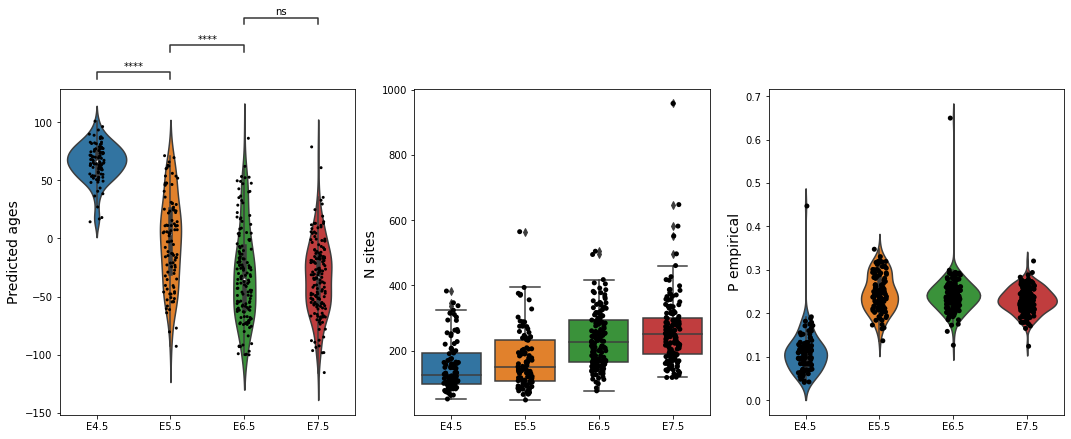

In [63]:
from statannot import add_stat_annotation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
sns.stripplot(x='Stage', y='Ages', data=data, ax=axes[0], color='black', s=3)
test_results = add_stat_annotation(axes[0], data=data, x='Stage', y='Ages',
                                   box_pairs=[('E4.5', 'E5.5'), 
                                              ('E5.5', 'E6.5'),
                                              ('E6.5', 'E7.5')
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=1)
axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MEF v.s. Hepatocyte
(4 month): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.400e+01
Hepatocyte
(4 month) v.s. Hepatocyte
(26 month): Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.698e-03 U_stat=1.000e+01


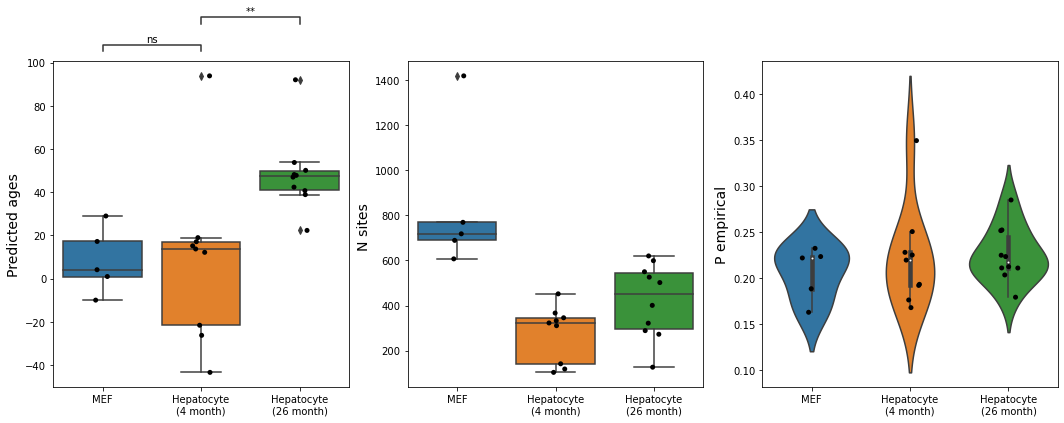

In [56]:
from statannot import add_stat_annotation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(x='Stage', y='Ages', data=data, ax=axes[0])
sns.stripplot(x='Stage', y='Ages', data=data, ax=axes[0], color='black')
test_results = add_stat_annotation(axes[0], data=data, x='Stage', y='Ages',
                                   box_pairs=[('MEF', 'Hepatocyte\n(4 month)'), 
                                              ('Hepatocyte\n(4 month)', 'Hepatocyte\n(26 month)'),
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=1)

axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);

# Other